In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
def create_rul_targets(data_length, max_rul=125):
    """
    Create target RUL values. RUL decreases linearly until it hits 0 or the max_rul.
    """
    if data_length < max_rul:
        return np.arange(data_length-1, -1, -1)
    else:
        return np.concatenate([max_rul*np.ones(data_length - max_rul), np.arange(max_rul-1, -1, -1)])

In [6]:
def create_windows(input_data, rul_targets=None, window_size=1, shift=1):
    """
    Split data into sliding windows ,
    If RUL target is provided, returns both windows and corresponding targets.
    """
    num_samples = (len(input_data) - window_size) // shift + 1
    windows = []
    targets = []

    for i in range(num_samples):
        window = input_data[i*shift:i*shift+window_size]
        windows.append(window)
        if rul_targets is not None:
            targets.append(rul_targets[i*shift + window_size - 1])

    windows = np.array(windows)
    
    # If targets are provided, return both windows and targets
    if rul_targets is not None:
        return windows, np.array(targets)
    
    # If no targets, return only windows
    return windows

In [4]:
def prepare_test_data(test_data, window_size, shift, num_windows=1):
    """
    Prepare test data to match shape and format 
    """
    max_samples = (len(test_data) - window_size) // shift + 1
    if max_samples < num_windows:
        num_windows = max_samples
    
    start_index = len(test_data) - (window_size + shift * (num_windows - 1))
    windows = create_windows(test_data[start_index:], window_size=window_size, shift=shift)
    return windows, num_windows

In [7]:
# Load the datasets
train_data = pd.read_csv("train_FD001.txt", sep="\s+", header=None)
test_data = pd.read_csv("test_FD001.txt", sep="\s+", header=None)
true_rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None).values.flatten()

# Drop unnecessary columns ( Operational Settings and Anomalous / Constant Columns)
drop_columns = [0, 1, 2, 3, 4, 5, 9, 10, 14, 20, 22, 23]

# Initialize parameters
window_size = 30  # Size of the sliding window
shift = 1         # How much to move the window each time
max_rul = 125     # Early RUL threshold
num_test_windows = 5  # How many windows from the end to take for testing

train_windows = []
train_targets = []
test_windows = []
num_windows_list = []

# Process training and test data for each engine
for engine_id in train_data[0].unique():
    # Get data for the current engine
    train_engine_data = train_data[train_data[0] == engine_id].drop(columns=drop_columns).values
    test_engine_data = test_data[test_data[0] == engine_id].drop(columns=drop_columns).values

    # Create RUL targets for training
    rul_targets = create_rul_targets(len(train_engine_data), max_rul=max_rul)
    
    # Create sliding windows for the training data
    train_wins, train_targs = create_windows(train_engine_data, rul_targets, window_size=window_size, shift=shift)
    train_windows.append(train_wins)
    train_targets.append(train_targs)

    # Process the test data into windows
    test_wins, num_wins = prepare_test_data(test_engine_data, window_size=window_size, shift=shift, num_windows=num_test_windows)
    test_windows.append(test_wins)
    num_windows_list.append(num_wins)

# Combine all the training and test data
train_windows = np.vstack(train_windows)
train_targets = np.concatenate(train_targets)
test_windows = np.vstack(test_windows)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0d/r3vrp3zx7cl6gg7mdmnb4w_80000gn/T/ipykernel_48707/3746923138.py:2: SyntaxWarning: invalid escape sequence '\s'
  train_data = pd.read_csv("train_FD001.txt", sep="\s+", header=None)
/var/folders/0d/r3vrp3zx7cl6gg7mdmnb4w_80000gn/T/ipykernel_48707/3746923138.py:3: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv("test_FD001.txt", sep="\s+", header=None)
/var/folders/0d/r3vrp3zx7cl6gg7mdmnb4w_80000gn/T/ipykernel_48707/3746923138.py:4: SyntaxWarning: invalid escape sequence '\s'
  true_rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None).values.flatten()


In [8]:
# Flatten the sliding windows for model training
train_windows = train_windows.reshape(train_windows.shape[0], -1)
test_windows = test_windows.reshape(test_windows.shape[0], -1)

In [9]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs = -1 , random_state=38)
rf_model.fit(train_windows, train_targets)

# Predict the RUL on test data
rul_predictions = rf_model.predict(test_windows)

# Calculate the average RUL prediction for each engine
preds_per_engine = np.split(rul_predictions, np.cumsum(num_windows_list)[:-1])
mean_rul_pred = [np.mean(pred) for pred in preds_per_engine]

# Calculate RMSE (root mean squared error)
rmse = np.sqrt(mean_squared_error(true_rul, mean_rul_pred))
print(f"RMSE: {rmse}")

RMSE: 19.269406532636133


In [17]:
def calculate_s_score(true_rul, pred_rul):
    s_score = 0
    for true, pred in zip(true_rul, pred_rul):
        error = pred - true
        if error > 0:  # Overestimation
            s_score += (np.exp(error / 13.0) - 1)
        else:  # Underestimation
            s_score += (np.exp(-error / 10.0) - 1)
    return s_score

# Calculate the S-score for the predictions
s_score = calculate_s_score(true_rul, mean_rul_pred)
print(f"S-Score: {s_score}")

S-Score: 632.632537791125


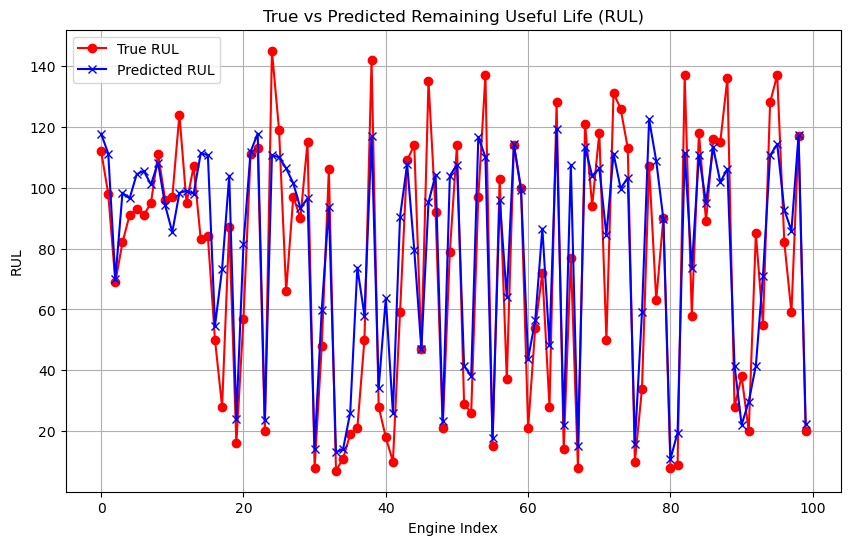

In [15]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL', color='red', marker='o', linestyle='solid')
plt.plot(mean_rul_pred, label='Predicted RUL', color='blue', marker='x', linestyle='solid')

# Add title and labels
plt.title('True vs Predicted Remaining Useful Life (RUL)')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)

# Show plot
plt.show()